In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tqdm import tqdm
from random import shuffle
import matplotlib.pyplot as plt
import tflearn
from tflearn.layers.conv import conv_2d,max_pool_2d
from tflearn.layers.core import input_data,dropout,fully_connected
from tflearn.layers.estimator import regression

Instructions for updating:
Use the retry module or similar alternatives.


In [6]:
TRAIN_DIR='/home/rahulchakwate/My_tensorflow/DataSets/cats_and_dogs_2/train'
TEST_DIR='/home/rahulchakwate/My_tensorflow/DataSets/cats_and_dogs_2/test'
IMG_SIZE=50
LR=1e-3
MODEL_NAME='cat-dog-convnet'
def create_label(image_name):
    word_label=image_name.split('.')[-3]
    if word_label=='cat':
        return np.array([1,0])
    elif word_label=='dog':
        return np.array([0,1])


In [7]:
def create_train_data():
    training_data=[]
    for img in tqdm(os.listdir(TRAIN_DIR)):
        path=os.path.join(TRAIN_DIR,img)
        img_data=cv2.imread(path,cv2.IMREAD_COLOR)
        img_data=cv2.resize(img_data,(IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img_data),create_label(img)])
    shuffle(training_data)
    np.save('train_data.npy',training_data)
    return training_data



In [8]:
def create_test_data():
    testing_data=[]
    for img in tqdm(os.listdir(TEST_DIR)):
        path=os.path.join(TEST_DIR,img)
        img_num=img.split('.')[0]
        img_data=cv2.imread(path,cv2.IMREAD_COLOR)
        img_data=cv2.resize(img_data,(IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img_data),img_num])
    shuffle(testing_data)
    np.save('test_data.npy',testing_data)
    return testing_data

In [9]:
train_data=create_train_data()

100%|██████████| 25000/25000 [06:29<00:00, 64.13it/s]


In [11]:
test_data=create_test_data()

100%|██████████| 12500/12500 [03:10<00:00, 65.65it/s]


In [12]:
train=train_data[:-1000]
test=train_data[-1000:]
X_train=np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y_train=np.array([i[1] for i in train])
X_val=np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y_val=np.array([i[1] for i in test])
print(X_train.shape)
print(y_train.shape)

(24000, 50, 50, 3)
(24000, 2)


In [14]:
tf.reset_default_graph()
convnet=input_data(shape=[None,IMG_SIZE,IMG_SIZE,3],name='input')
convnet=conv_2d(convnet,32,5,activation='relu')
convnet=max_pool_2d(convnet,5)
convnet=conv_2d(convnet,64,5,activation='relu')
convnet=max_pool_2d(convnet,5)
convnet=conv_2d(convnet,128,5,activation='relu')
convnet=max_pool_2d(convnet,5)
convnet=conv_2d(convnet,64,5,activation='relu')
convnet=max_pool_2d(convnet,5)
convnet=conv_2d(convnet,32,5,activation='relu')
convnet=max_pool_2d(convnet,5)
convnet=fully_connected(convnet,1024,activation='relu')
convnet=dropout(convnet,0.8)
convnet=fully_connected(convnet,2,activation='softmax')
convnet=regression(convnet,optimizer='adam',learning_rate=LR,loss='categorical_crossentropy',name='targets')

model=tflearn.DNN(convnet,tensorboard_dir='log',tensorboard_verbose=0)

model.fit({'input':X_train},{'targets':y_train},n_epoch=10,validation_set=({'input':X_val},{'targets':y_val}),snapshot_step=500, show_metric=True, run_id=MODEL_NAME)


Training Step: 3749  | total loss: 0.28227 | time: 83.092s
| Adam | epoch: 010 | loss: 0.28227 - acc: 0.8795 -- iter: 23936/24000
Training Step: 3750  | total loss: 0.26909 | time: 84.615s
| Adam | epoch: 010 | loss: 0.26909 - acc: 0.8853 | val_loss: 0.50540 - val_acc: 0.7920 -- iter: 24000/24000
--


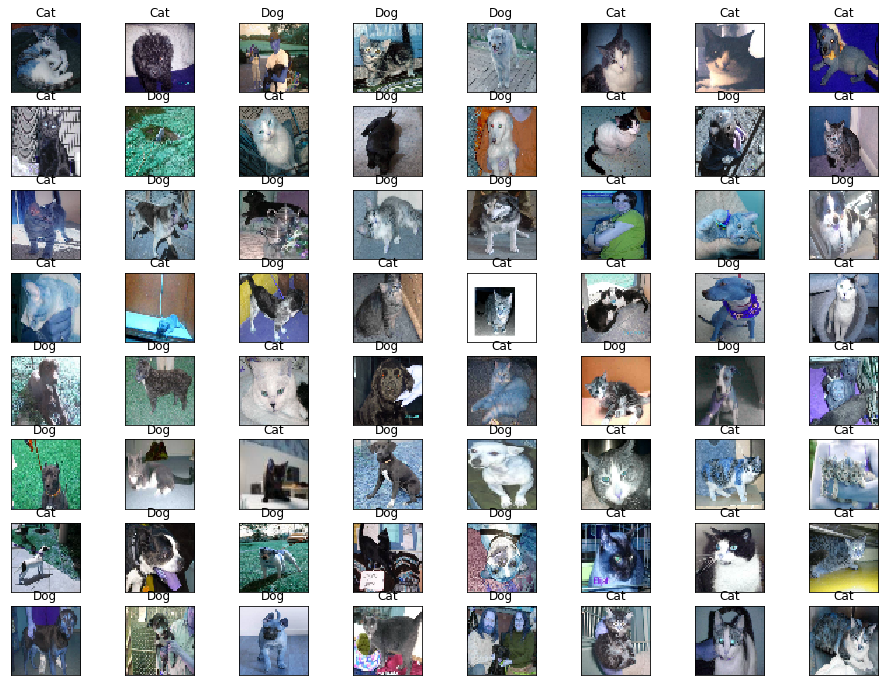

In [19]:
fig=plt.figure(figsize=(16,12))

for num,data in enumerate(test_data[100:164]):
    img_num=data[1]
    img_data=data[0]
    y=fig.add_subplot(8,8,num+1)
    orig=img_data
    data=img_data.reshape(IMG_SIZE,IMG_SIZE,3)
    model_out=model.predict([data])[0]
    
    if np.argmax(model_out)==1:
        str_label='Dog'
    else:
        str_label='Cat'
        
    y.imshow(orig)
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()